In [1]:
solver = "appsi_highs"

import pyomo.environ as pyo

SOLVER = pyo.SolverFactory(solver)

assert SOLVER.available(), f"Solver {solver} is not available."

In [2]:
def shift_schedule(N=10, hours=40):
    m = pyo.ConcreteModel("Workforce Shift Scheduling")

    # ordered set of avaiable workers
    m.W = pyo.Set(initialize=[f"W{i:02d}" for i in range(1, N + 1)])

    # ordered sets of days and shifts
    m.D = pyo.Set(initialize=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    m.S = pyo.Set(initialize=["morning", "evening", "night"])

    # ordered set of day, shift time slots
    m.T = pyo.Set(initialize=m.D * m.S)

    # ordered set of 24-hour time blocks
    m.B = pyo.Set(
        initialize=[
            [m.T.at(i), m.T.at(i + 1), m.T.at(i + 2)] for i in range(1, len(m.T) - 1)
        ]
    )

    # ordered set of weekend shifts
    m.E = pyo.Set(initialize=m.T, filter=lambda m, day, shift: day in ["Sat", "Sun"])

    # parameter of worker requirements
    @m.Param(m.T)
    def R(m, day, shift):
        if shift in ["night"] or day in ["Sun"]:
            return 1
        return 2

    # max hours per week per worker
    m.H = pyo.Param(mutable=True, default=hours)

    # decision variable: a[worker, day, shift] = 1 assigns worker to a time slot
    m.a = pyo.Var(m.W, m.T, domain=pyo.Binary)

    # decision variables: e[worker] = 1 worker is assigned weekend shift
    m.e = pyo.Var(m.W, domain=pyo.Binary)

    # decision variable: n[worker] = 1
    m.n = pyo.Var(m.W, domain=pyo.Binary)

    # assign a sufficient number of workers for each time slot
    @m.Constraint(m.T)
    def required_workers(m, day, shift):
        return m.R[day, shift] == sum(m.a[worker, day, shift] for worker in m.W)

    # workers limited to forty hours per week assuming 8 hours per shift
    @m.Constraint(m.W)
    def forty_hour_limit(m, worker):
        return 8 * sum(m.a[worker, day, shift] for day, shift in m.T) <= m.H

    # workers are assigned no more than one time slot per 24 time block
    @m.Constraint(m.W, m.B)
    def required_rest(m, worker, d1, s1, d2, s2, d3, s3):
        return m.a[worker, d1, s1] + m.a[worker, d2, s2] + m.a[worker, d3, s3] <= 1

    # determine if a worker is assigned to any shift
    @m.Constraint(m.W)
    def is_needed(m, worker):
        return (
            sum(m.a[worker, day, shift] for day, shift in m.T) <= len(m.T) * m.n[worker]
        )

    # determine if a worker is assigned to a weekend shift
    @m.Constraint(m.W)
    def is__weekend(m, worker):
        return sum(m.a[worker, day, shift] for day, shift in m.E) <= 6 * m.e[worker]

    # minimize a blended objective of needed workers and needed weekend workers
    @m.Objective(sense=pyo.minimize)
    def minimize_workers(m):
        return sum(
            i * m.n[worker] + 0.1 * i * m.e[worker] for i, worker in enumerate(m.W)
        )

    return m

m = shift_schedule(10, 40)
_ = SOLVER.solve(m)

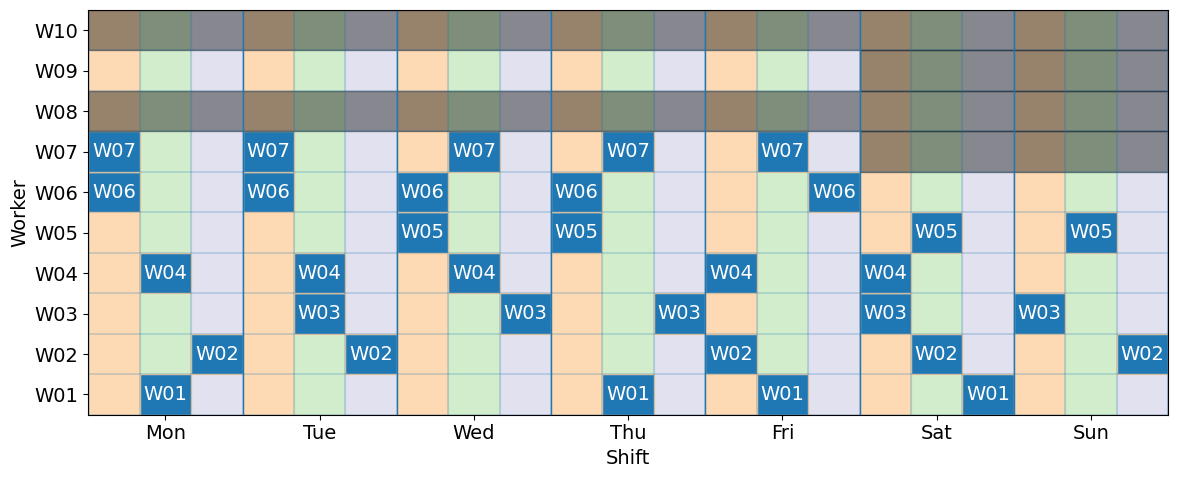

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


def visualize(m):
    bw = 1.0
    workers = [worker for worker in m.W]
    plt.rcParams["font.size"] = 14
    fig, ax = plt.subplots(1, 1, figsize=(12, 2 + 0.3 * len(m.W)))

    colormap = plt.cm.tab20c.colors
    colors = [colormap[7], colormap[11], colormap[15]]
    for i in range(len(m.T) + 1):
        ax.axvline(i, lw=0.3)
        ax.fill_between(
            [i, i + 1], [0] * 2, [len(m.W)] * 2, alpha=0.8, color=colors[i % 3]
        )
    for i in range(len(m.D) + 1):
        ax.axvline(3 * i, lw=1)

    ax.set_xlim(0, len(m.T))
    ax.set_xticks([3 * i + 1.5 for i in range(len(m.D))])
    ax.set_xticklabels(m.D)
    ax.set_xlabel("Shift")

    ax.set_ylim(0, len(m.W))
    for j in range(len(m.W) + 1):
        ax.axhline(j, lw=0.3)
    ax.set_yticks([j + 0.5 for j in range(len(m.W))])
    ax.set_yticklabels(workers)
    ax.set_ylabel("Worker")

    # show shift assignments
    for i, slot in enumerate(m.T):
        day, shift = slot
        for j, worker in enumerate(m.W):
            if round(m.a[worker, day, shift]()):
                ax.add_patch(
                    Rectangle((i, j + (1 - bw) / 2), 1, bw, edgecolor=colors[0])
                )
                ax.text(
                    i + 1 / 2, j + 1 / 2, worker, ha="center", va="center", color="w"
                )

    # display needed and weekend data
    for j, worker in enumerate(m.W):
        if not m.n[worker]():
            ax.fill_between([0, len(m.T)], [j, j], [j + 1, j + 1], color="k", alpha=0.4)
        if m.n[worker]() and not m.e[worker]():
            ax.fill_between(
                [15, len(m.T)], [j, j], [j + 1, j + 1], color="k", alpha=0.4
            )
    plt.tight_layout()
    plt.show()

visualize(m)

In [5]:
import pandas as pd

schedule = pd.DataFrame(
    [[w, d, s] for w in m.W for d, s in m.T if m.a[w, d, s]()],
    columns=["worker", "day", "shift"],
)

# create and assign a worker category type
worker_type = pd.CategoricalDtype(categories=m.W, ordered=True)
schedule["worker"] = schedule["worker"].astype(worker_type)

# create and assign a day category type
day_type = pd.CategoricalDtype(categories=m.D, ordered=True)
schedule["day"] = schedule["day"].astype(day_type)

# create and assign a shift category type
shift_type = pd.CategoricalDtype(categories=m.S, ordered=True)
schedule["shift"] = schedule["shift"].astype(shift_type)

# demonstrate sorting and display of the master schedule
schedule.sort_values(by=["day", "shift", "worker"])

,worker,day,shift
9,W03,Mon,morning
26,W06,Mon,morning
37,W07,Mon,morning
0,W01,Mon,evening
15,W04,Mon,evening
27,W06,Mon,evening
44,W09,Mon,evening
4,W02,Mon,night
20,W05,Tue,morning
28,W06,Tue,morning


In [6]:
# sort schedule by worker
schedule = schedule.sort_values(by=["worker", "day", "shift"])

# print worker schedules
for worker, worker_schedule in schedule.groupby("worker"):
    print(f"\nWork schedule for {worker}")
    if len(worker_schedule) > 0:
        for s in worker_schedule.to_string(index=False).split("\n"):
            print(s)
    else:
        print("   no assigned shifts")


Work schedule for W01
worker day   shift
   W01 Mon evening
   W01 Thu evening
   W01 Fri evening
   W01 Sat   night

Work schedule for W02
worker day   shift
   W02 Mon   night
   W02 Tue   night
   W02 Fri morning
   W02 Sat evening
   W02 Sun   night

Work schedule for W03
worker day   shift
   W03 Mon morning
   W03 Tue evening
   W03 Wed   night
   W03 Thu   night
   W03 Sat morning
   W03 Sun morning

Work schedule for W04
worker day   shift
   W04 Mon evening
   W04 Tue evening
   W04 Wed evening
   W04 Fri morning
   W04 Sat morning

Work schedule for W05
worker day   shift
   W05 Tue morning
   W05 Wed morning
   W05 Thu morning
   W05 Fri evening
   W05 Sat evening
   W05 Sun evening

Work schedule for W06
worker day   shift
   W06 Mon morning
   W06 Mon evening
   W06 Tue morning
   W06 Tue evening
   W06 Wed morning
   W06 Wed evening
   W06 Thu morning
   W06 Thu evening
   W06 Fri morning
   W06 Fri   night
   W06 Sat morning

Work schedule for W07
worker day   shift
   

C:\Users\radoa\AppData\Local\Temp\ipykernel_14056\690829760.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for worker, worker_schedule in schedule.groupby("worker"):


In [7]:
# sort by day, shift, worker
schedule = schedule.sort_values(by=["day", "shift", "worker"])

for day, day_schedule in schedule.groupby("day"):
    print(f"\nShift schedule for {day}")
    for shift, shift_schedule in day_schedule.groupby("shift"):
        print(f"   {shift} shift: ", end="")
        print(", ".join([worker for worker in shift_schedule["worker"].values]))


Shift schedule for Mon
   morning shift: W03, W06, W07
   evening shift: W01, W04, W06, W09
   night shift: W02

Shift schedule for Tue
   morning shift: W05, W06, W07
   evening shift: W03, W04, W06
   night shift: W02, W07, W09

Shift schedule for Wed
   morning shift: W05, W06
   evening shift: W04, W06, W07
   night shift: W03, W09

Shift schedule for Thu
   morning shift: W05, W06, W07
   evening shift: W01, W06, W07
   night shift: W03, W09

Shift schedule for Fri
   morning shift: W02, W04, W06
   evening shift: W01, W05, W07
   night shift: W06, W09

Shift schedule for Sat
   morning shift: W03, W04, W06
   evening shift: W02, W05
   night shift: W01

Shift schedule for Sun
   morning shift: W03
   evening shift: W05
   night shift: W02


C:\Users\radoa\AppData\Local\Temp\ipykernel_14056\3457082458.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for day, day_schedule in schedule.groupby("day"):
C:\Users\radoa\AppData\Local\Temp\ipykernel_14056\3457082458.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for shift, shift_schedule in day_schedule.groupby("shift"):
